# Bayesian Interleaved and Accelerated Randomized Benchmarking


In [1]:
#Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
#from IPython import display

#Import Qiskit classes
import qiskit
from qiskit.tools.monitor import job_monitor
from qiskit import Aer
from qiskit.providers.aer.noise import NoiseModel
from qiskit import  QuantumRegister, QuantumCircuit
#Import the RB Functions
import qiskit.ignis.verification.randomized_benchmarking as rb

# import the bayesian packages
import pymc3 as pm
import arviz as az
from scipy.optimize import curve_fit
import bayesian_fitter as bf

In [2]:
# initialize the Bayesian extension
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Parameters of the RB Run <a name='select_params_RB'></a>


- **nseeds:** The number of seeds. For each seed you will get a separate list of output circuits in rb_circs.
- **length_vector:** The length vector of Clifford lengths. Must be in ascending order. RB sequences of increasing length grow on top of the previous sequences.
- **rb_pattern:** A list of the form [[i,j],[k],...] which will make simultaneous RB sequences where Qi,Qj are a 2-qubit RB sequence and Qk is a 1-qubit sequence, etc. The number of qubits is the sum of the entries. For 'regular' RB the qubit_pattern is just [[0]],[[0,1]].
- **length_multiplier:** If this is an array it scales each rb_sequence by the multiplier.
- **seed_offset:** What to start the seeds at (e.g. if we want to add more seeds later).
- **align_cliffs:**  If true adds a barrier across all qubits in rb_pattern after each set of cliffords.

In [3]:
RB_process = "1_Q RB"

if RB_process in ["3_Q RB","2-3_Q RB"] :
    #Number of qubits
    nQ = 3
    #There are 3 qubits: Q0,Q1,Q2.
    #2Q RB on Q0,Q2 and 1Q RB on Q1
    rb_pattern = [[1,2],[3]] # because 3 qubits
    #Do three times as many 1Q Cliffords    
    length_multiplier = [1,3]
    #Interleaved Clifford gates (2-qubits and 1-qubit)
    interleaved_gates = [['cx 0 1'],['x 2']]

elif RB_process == "2_Q RB":
    #Number of qubits
    nQ = 2
    #There are 2 qubits: Q0,Q1.
    #2Q RB Q0,Q1
    rb_pattern = [[0,1]]
    length_multiplier = 1
    interleaved_gates = [['cx 0,1']]
    
elif RB_process == "1_Q RB":
    #Number of qubits
    nQ = 1
    #There is 1 qubit: Q0
    rb_pattern = [[0]]
    length_multiplier = 1
    interleaved_gates = [['sx 0']]

#Important parameters
#Number of Cliffords in the sequence (start, stop, steps)
nCliffs = [1, 50, 100, 200, 400, 600, 800, 1000, 1300, 1600]
#Number of seeds (random sequences)
nseeds=8
#Shots 
shots = 2**9

scale = (2 ** len(rb_pattern[0]) - 1) / (2 ** len(rb_pattern[0]))

In [4]:
from qiskit import IBMQ
from qiskit import Aer
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

device = provider.get_backend('ibmq_athens') # type here hardware backend
properties = device.properties()
coupling_map = device.configuration().coupling_map
basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset']
hardware = device.name()
run_option = "real"          # "simulation"
# choice of simulation or real device run
if run_option == "real":
    backend = device
    noise_model = None
elif run_option == "simulation":    
    backend = Aer.get_backend('qasm_simulator')
    noise_model = NoiseModel.from_backend(properties)

#### start skippable section for model rerun

In [5]:
qregs_02 = QuantumRegister(2)
circ_02 = QuantumCircuit(qregs_02, name='circ_02')
#circ_02.h(qregs_02[0]) # booptrap! WIP!
circ_02.cx(qregs_02[0], qregs_02[1])
circ_02.draw()

q0_0: ──■──
      ┌─┴─┐
q0_1: ┤ X ├
      └───┘

In [6]:
qregs_1 = QuantumRegister(1)
circ_1 = QuantumCircuit(qregs_1, name='circ_1')
circ_1.sx(qregs_1[0]) # booptrap! WIP!
circ_1.draw()

┌────┐
q1_0: ┤ √X ├
      └────┘

## Generate the RB sequences <a name='gen_RB_seq'></a>

In order to generate the RB sequences **rb_circs**, which is a list of lists of quantum circuits, 
we run the function `rb.randomized_benchmarking_seq`.

This function returns:

- **rb_circs:** A list of lists of circuits for the rb sequences (separate list for each seed).
- **xdata:** The Clifford lengths (with multiplier if applicable).

In [7]:
rb_opts = {}
rb_opts['rand_seed'] = 61946
rb_opts['length_vector'] = nCliffs
rb_opts['nseeds'] = nseeds
rb_opts['rb_pattern'] = rb_pattern
rb_opts['length_multiplier'] = length_multiplier
#rb_opts['align_cliffs'] = True
if RB_process in ["3_Q RB","2-3_Q RB"]:
    rb_opts['interleaved_elem'] = [circ_02, circ_1]
elif RB_process == "2_Q RB":
    rb_opts['interleaved_elem'] = [circ_02]
elif RB_process == "1_Q RB":
    rb_opts['interleaved_elem'] = [circ_1]
rb_original_circs, xdata, rb_interleaved_circs = rb.randomized_benchmarking_seq(**rb_opts)

In [8]:
#Original RB circuits
print (rb_original_circs[0][0])

      ┌───┐┌───┐┌───┐┌───┐ ░ ┌─────┐┌───┐┌─────┐┌───┐┌─┐
qr_0: ┤ Z ├┤ S ├┤ H ├┤ S ├─░─┤ SDG ├┤ H ├┤ SDG ├┤ Z ├┤M├
      └───┘└───┘└───┘└───┘ ░ └─────┘└───┘└─────┘└───┘└╥┘
cr: 1/════════════════════════════════════════════════╩═
                                                      0 


In [9]:
#Interleaved RB circuits
print (rb_interleaved_circs[0][0])

      ┌───┐┌───┐┌───┐┌───┐ ░ ┌────┐ ░ ┌───┐┌─┐
qr_0: ┤ Z ├┤ S ├┤ H ├┤ S ├─░─┤ √X ├─░─┤ Z ├┤M├
      └───┘└───┘└───┘└───┘ ░ └────┘ ░ └───┘└╥┘
cr: 1/══════════════════════════════════════╩═
                                            0 


 # Execute the RB sequences

In [10]:
retrieve_list = []

In [ ]:
original_result_list, original_transpile_list = bf.get_and_run_seeds(rb_circs=rb_original_circs,
                                               shots=shots,
                                               backend = backend,
                                               coupling_map = coupling_map,
                                               basis_gates = basis_gates,
                                               noise_model = noise_model,
                                               retrieve_list=retrieve_list)                                                

In [ ]:
retrieve_list = []

In [ ]:
interleaved_result_list, interleaved_transpile_list = bf.get_and_run_seeds(rb_circs=rb_interleaved_circs,
                                               shots=shots,
                                               backend = backend,
                                               coupling_map = coupling_map,
                                               basis_gates = basis_gates,
                                               noise_model = noise_model,
                                               retrieve_list=retrieve_list)                                                

#### end skippable section for model rerun

### interpolation for the reference gate  error 

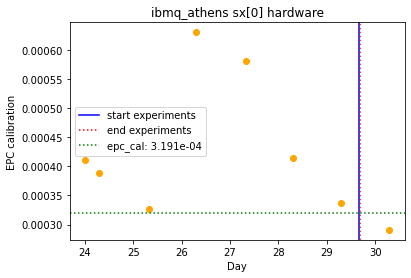

In [24]:
epc_ref = 0.0003191 

### Retrieve counts

Data are printed. So in order to rerun the models, it is possible to recuperate the data here after skipping most of previous steps.
The cells with tag obligatory must however be run

In [25]:
# skip if no model rerun
Y1 =np.array([[507, 503, 493, 478, 445, 423, 394, 390, 344, 310],
       [506, 505, 497, 480, 447, 439, 415, 401, 383, 354],
       [509, 501, 501, 487, 453, 443, 422, 414, 369, 352],
       [511, 507, 497, 483, 450, 424, 397, 374, 332, 322],
       [508, 505, 493, 482, 452, 452, 427, 408, 366, 339],
       [511, 503, 490, 480, 456, 435, 418, 399, 369, 364],
       [510, 499, 495, 484, 432, 409, 417, 374, 374, 350],
       [508, 503, 487, 484, 470, 440, 416, 369, 363, 338]])

In [26]:
# skip if no model rerun
Y2 = np.array([[508, 494, 470, 462, 406, 376, 359, 360, 324, 334],
       [509, 489, 477, 450, 421, 395, 356, 340, 316, 300],
       [509, 494, 473, 455, 426, 397, 355, 327, 317, 320],
       [510, 498, 475, 444, 406, 355, 326, 323, 278, 271],
       [508, 492, 479, 455, 411, 389, 358, 335, 306, 307],
       [509, 497, 487, 448, 412, 365, 351, 328, 304, 292],
       [512, 499, 483, 455, 395, 390, 345, 331, 292, 306],
       [509, 498, 475, 451, 408, 388, 366, 344, 316, 300]])

### Least squares fit: standard RB

In [27]:
# function to optimize
def lsf(x, a, alpha, b):
    return a * alpha ** x + b

In [28]:
# curve fit

popt_s,pcov_s = curve_fit(lsf, np.array(nseeds*list(nCliffs)),
                          np.ravel(Y1)/shots,
                          bounds = ([scale-0.15,.9,1-scale-.15],
                                    [scale+0.15,1.0,1-scale+.15]))
                                
perr_s= np.sqrt(np.diag(pcov_s))
# get EPC and EPC sigma for LSF accelerated
alpha_f = popt_s[1] 
alpha_f_err = perr_s[1] 
popt_s,perr_s

(array([0.64445188, 0.99955501, 0.35      ]),
 array([1.09666363e-01, 1.05916801e-04, 1.12082610e-01]))

### Least squares fit: interleaved  RB

In [29]:
# curve fit
popt_i,pcov_i = curve_fit(lsf, np.array(nseeds*list(nCliffs)),
                          np.ravel(Y2)/shots,
                          bounds = ([scale-0.15,.9,1-scale-.15],
                                    [scale+0.15,1.0,1-scale+.15]))
                                
perr_i= np.sqrt(np.diag(pcov_i))
# get EPC and EPC sigma for LSF accelerated
alphC_f = popt_i[1] 
alphC_f_err = perr_i[1] 
popt_i,perr_i

(array([0.46391488, 0.99866655, 0.53042978]),
 array([1.38266060e-02, 9.83560381e-05, 1.51096036e-02]))

####  Compute error per Clifford from 2-runs LSF

In [30]:
epc_est_f = scale*(1 - alphC_f/alpha_f)
epc_est_f_err = scale*(alphC_f/alpha_f)*(np.sqrt(alpha_f_err**2 + alphC_f_err**2))

### Least squares fit: accelerated version

model: [equation 6 in this paper](https://arxiv.org/abs/1404.5275) 

In [31]:
# function to optimize
def lsmf(x, a, alpha, p_tilde_m, b):
    return x[1]*(a * alpha ** x[0] + b) + x[2]*(a * (alpha*p_tilde_m) ** x[0] + b)

In [32]:
# obtain the data
m_len = len(nCliffs)*nseeds
x0_lsmf = np.array(nseeds*2*list(nCliffs))
x1_lsmf = np.hstack((np.ones(m_len),np.zeros(m_len)))
x2_lsmf = np.hstack((np.zeros(m_len),np.ones(m_len)))
x_lsmf = np.vstack((x0_lsmf,x1_lsmf,x2_lsmf))
y_lsmf=np.hstack((np.ravel(Y1),np.ravel(Y2)))/shots

In [33]:
# curve fit
popt_m,pcov_m = curve_fit(lsmf, x_lsmf, y_lsmf,
                    bounds = ([scale-0.15,.9,.9,1-scale-.15],
                             [scale+0.15,1.0,1.0,1-scale+.15]))
perr_m = np.sqrt(np.diag(pcov_m))
# get EPC and EPC sigma for LSF accelerated
alpha_fm = popt_m[1] 
p_tilde_m =  popt_m[2] 
alpha_fm_err = perr_m[1] 
p_tilde_m_err =  perr_m[2] 
popt_m,perr_m

(array([0.47526513, 0.99931259, 0.99939247, 0.52152427]),
 array([1.41737192e-02, 3.97664943e-05, 5.65042105e-05, 1.51209619e-02]))

####  Compute error per Clifford from  LSF accelerated RB

In [34]:
epc_est_fm = scale*(1 - p_tilde_m)
epc_est_fm_err = scale*p_tilde_m_err

In [35]:
# compare LSF and Reference
print("Model:           Frequentist              Reference")
print("            two-run      accelerated")
print("EPC         {0:.6f}       {1:.6f}          {2:.6f} "
      .format(epc_est_f, epc_est_fm, epc_ref))  
print("± sigma     ± {0:.6f}     ± {1:.6f}         ------ "
      .format(epc_est_f_err, epc_est_fm_err))

Model:           Frequentist              Reference
            two-run      accelerated
EPC         0.000444       0.000304          0.000319 
± sigma     ± 0.000072     ± 0.000028         ------ 


### Serial Monte Carlo: standard RB run

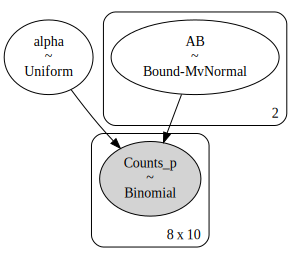

In [36]:
original_model = bf.get_bayesian_model(model_type="pooled",Y=Y1,shots=shots,m_gates=nCliffs,
                                       mu_AB=[popt_s[0],popt_s[2]],cov_AB=[perr_s[0],perr_s[2]],
                                       alpha_ref=alpha_f, alpha_upper=.999999, p_upper=.999999)

pm.model_to_graphviz(original_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [AB, alpha]


Sampling 4 chains for 10_000 tune and 2_000 draw iterations (40_000 + 8_000 draws total) took 1011 seconds.
The number of effective samples is smaller than 10% for some parameters.


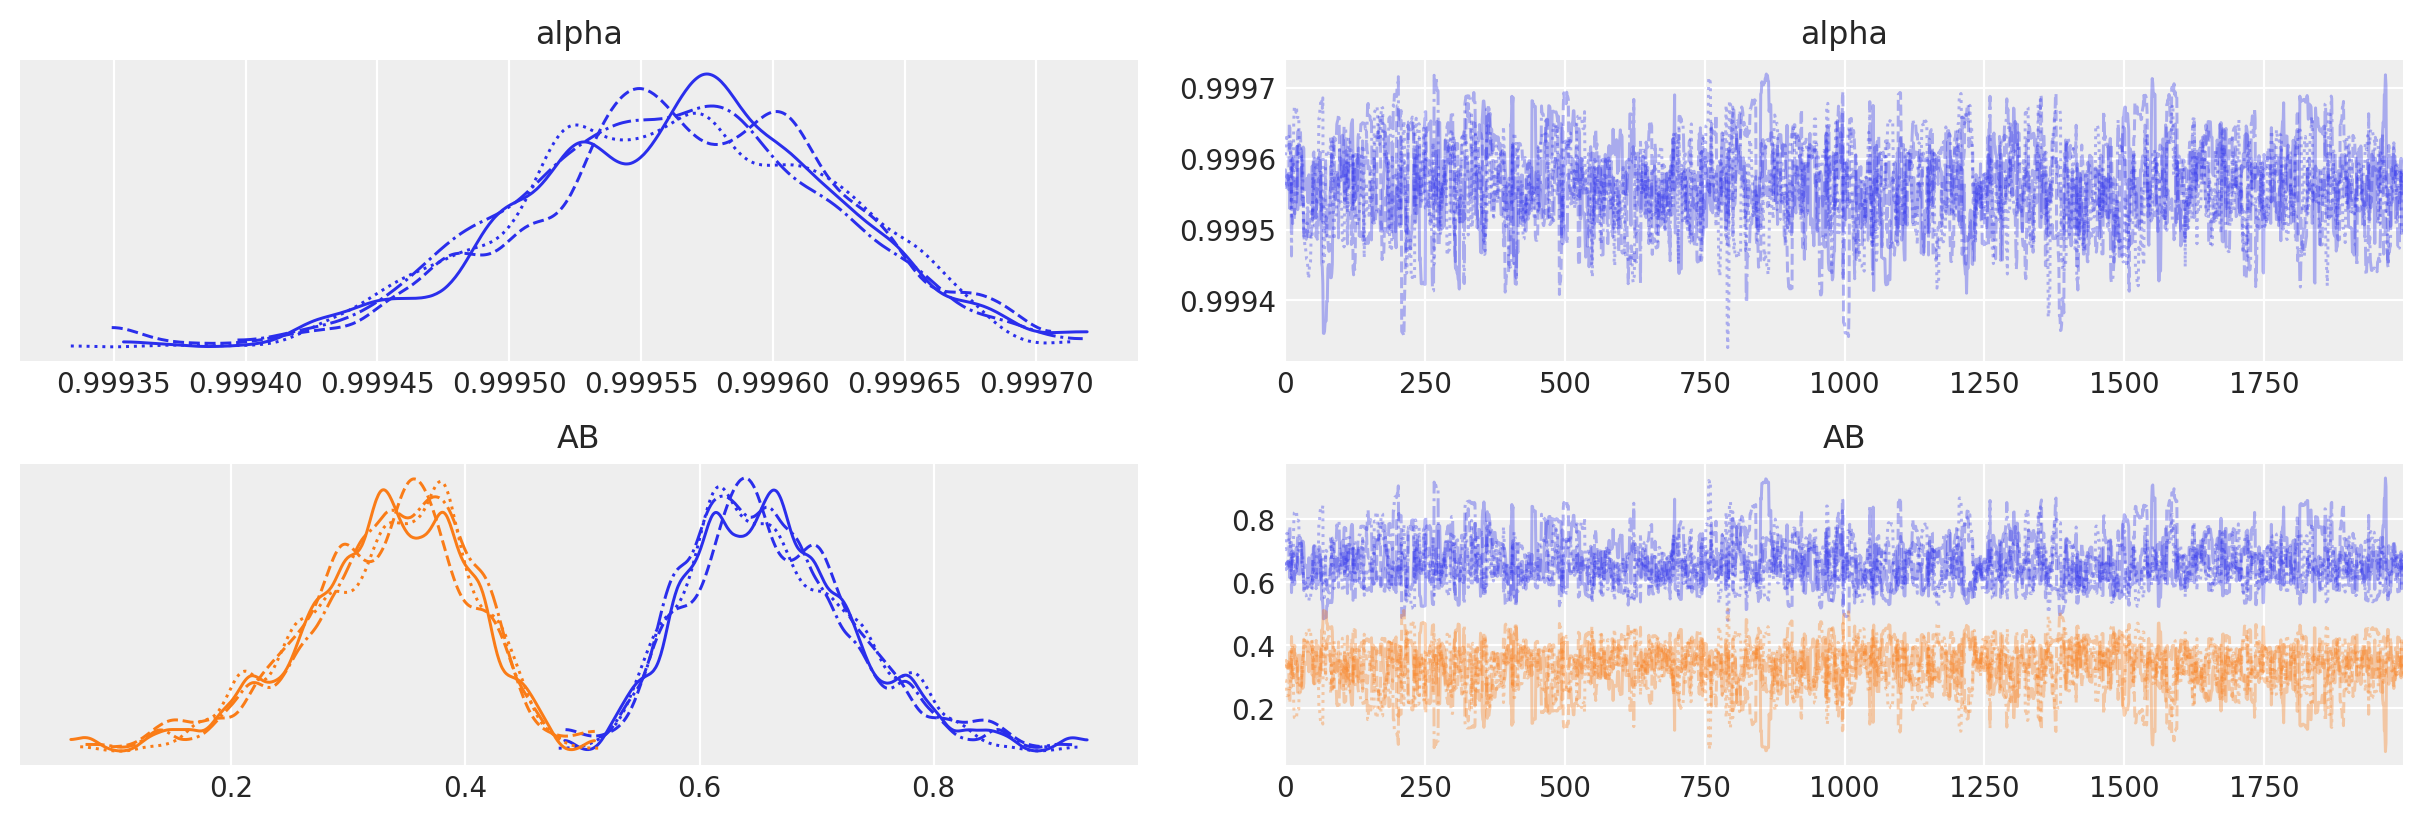

In [37]:
trace_o = bf.get_trace(original_model, target_accept = .99)

In [38]:
azo_summary = bf.get_summary(original_model, trace_o)
azo_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.999563,0.000060,0.999447,0.999668,0.000002,0.000002,739.166824,924.697710,1.003065
AB[0],0.662257,0.071924,0.539733,0.800293,0.002786,0.002018,725.099394,883.987746,1.003170
AB[1],0.332016,0.072198,0.191236,0.452633,0.002795,0.001978,725.309137,888.717552,1.003158


In [39]:
alpha_original_p = azo_summary['mean']['alpha']
alpha_original_p_err = azo_summary['sd']['alpha']

### Serial Monte Carlo: interleaved RB run

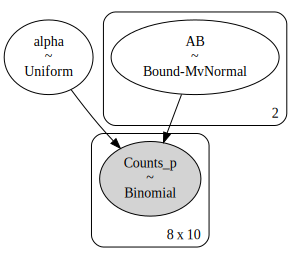

In [40]:
interleaved_model = bf.get_bayesian_model(model_type="pooled",Y=Y2,shots=shots,m_gates=nCliffs,
                                          mu_AB=[popt_i[0],popt_i[2]],cov_AB=[perr_i[0],perr_i[2]],
                                          alpha_ref=alpha_f, alpha_upper=.999999, p_upper=.999999)
pm.model_to_graphviz(interleaved_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [AB, alpha]


Sampling 4 chains for 10_000 tune and 2_000 draw iterations (40_000 + 8_000 draws total) took 169 seconds.
The number of effective samples is smaller than 25% for some parameters.


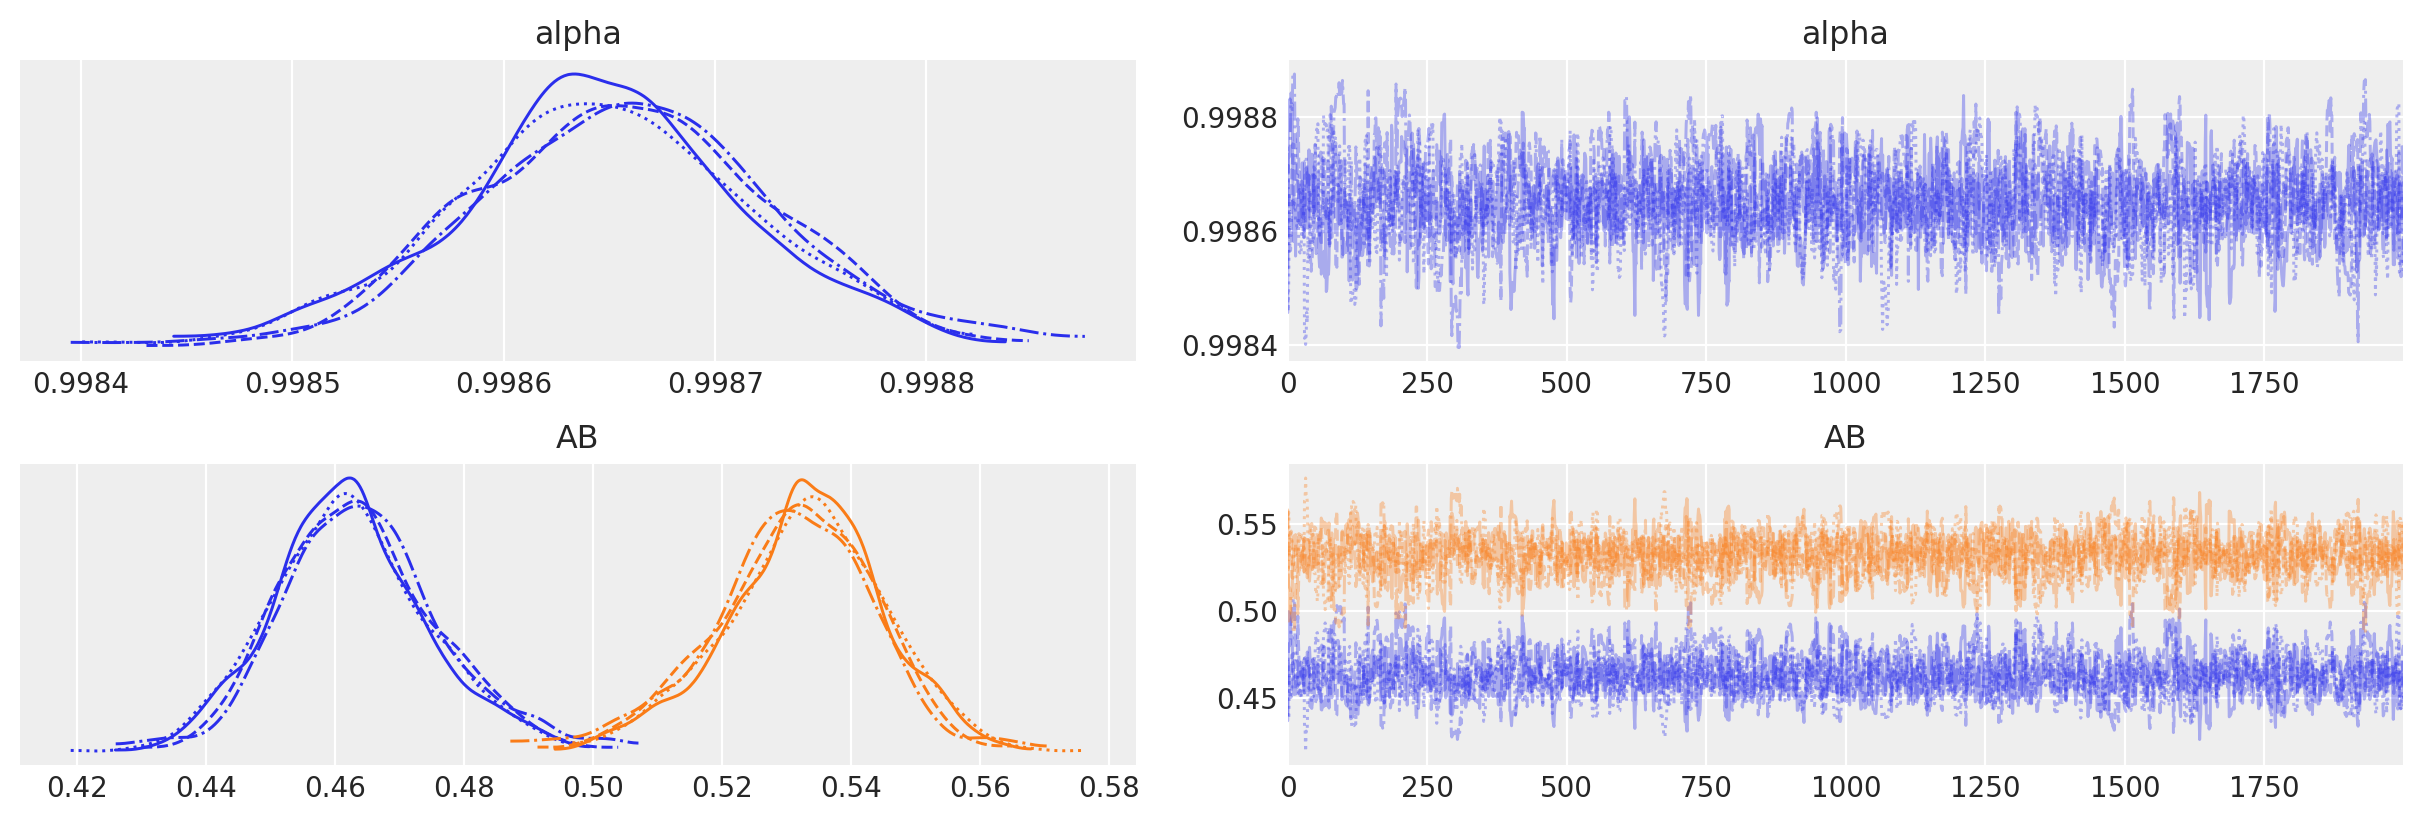

In [41]:
trace_i = bf.get_trace(interleaved_model, target_accept = .95)

In [42]:
azi_summary = bf.get_summary(interleaved_model, trace_i)
azi_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.998651,0.000070,0.998523,0.998788,0.000002,0.000002,1002.677436,1154.378895,1.011083
AB[0],0.463167,0.012218,0.439723,0.486373,0.000396,0.000281,966.514239,1066.473990,1.009818
AB[1],0.531842,0.012414,0.507578,0.554684,0.000404,0.000286,960.279564,1040.819276,1.010296


In [43]:
alpha_c_p = azi_summary['mean']['alpha']
alpha_c_p_err = azi_summary['sd']['alpha']

####  Compute error per Clifford from 2-runs SMC

In [44]:
epc_est_p = scale*(1 - alpha_c_p/alpha_original_p)
epc_est_p_err = scale*(alpha_c_p/alpha_original_p)*(np.sqrt(alpha_original_p_err**2 + alpha_c_p_err**2))

###  Serial Monte Carlo :  accelerated RB

model: [equation 6 in this paper](https://arxiv.org/abs/1404.5275) 

In [45]:
Y = np.vstack((Y1,Y2))
RvsI = np.vstack((np.ones_like(Y1),np.zeros_like(Y2)))
IvsR = np.vstack((np.zeros_like(Y1),np.ones_like(Y2)))

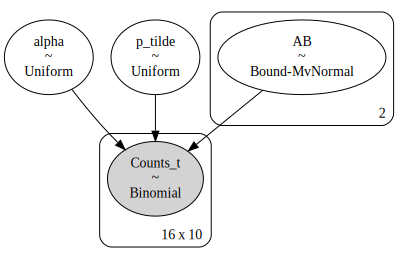

In [46]:
tilde =bf.get_bayesian_model("tilde",Y=Y,shots=shots, m_gates=nCliffs,
                             alpha_ref=alpha_fm, p_testval= p_tilde_m,
                             mu_AB=[popt_m[0],popt_m[3]],cov_AB=[perr_m[0],perr_m[3]],
                             RvsI=RvsI,IvsR=IvsR, alpha_upper=.999999, p_upper=.999999)
pm.model_to_graphviz(tilde)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_tilde, AB, alpha]


Sampling 4 chains for 10_000 tune and 2_000 draw iterations (40_000 + 8_000 draws total) took 298 seconds.
The number of effective samples is smaller than 25% for some parameters.


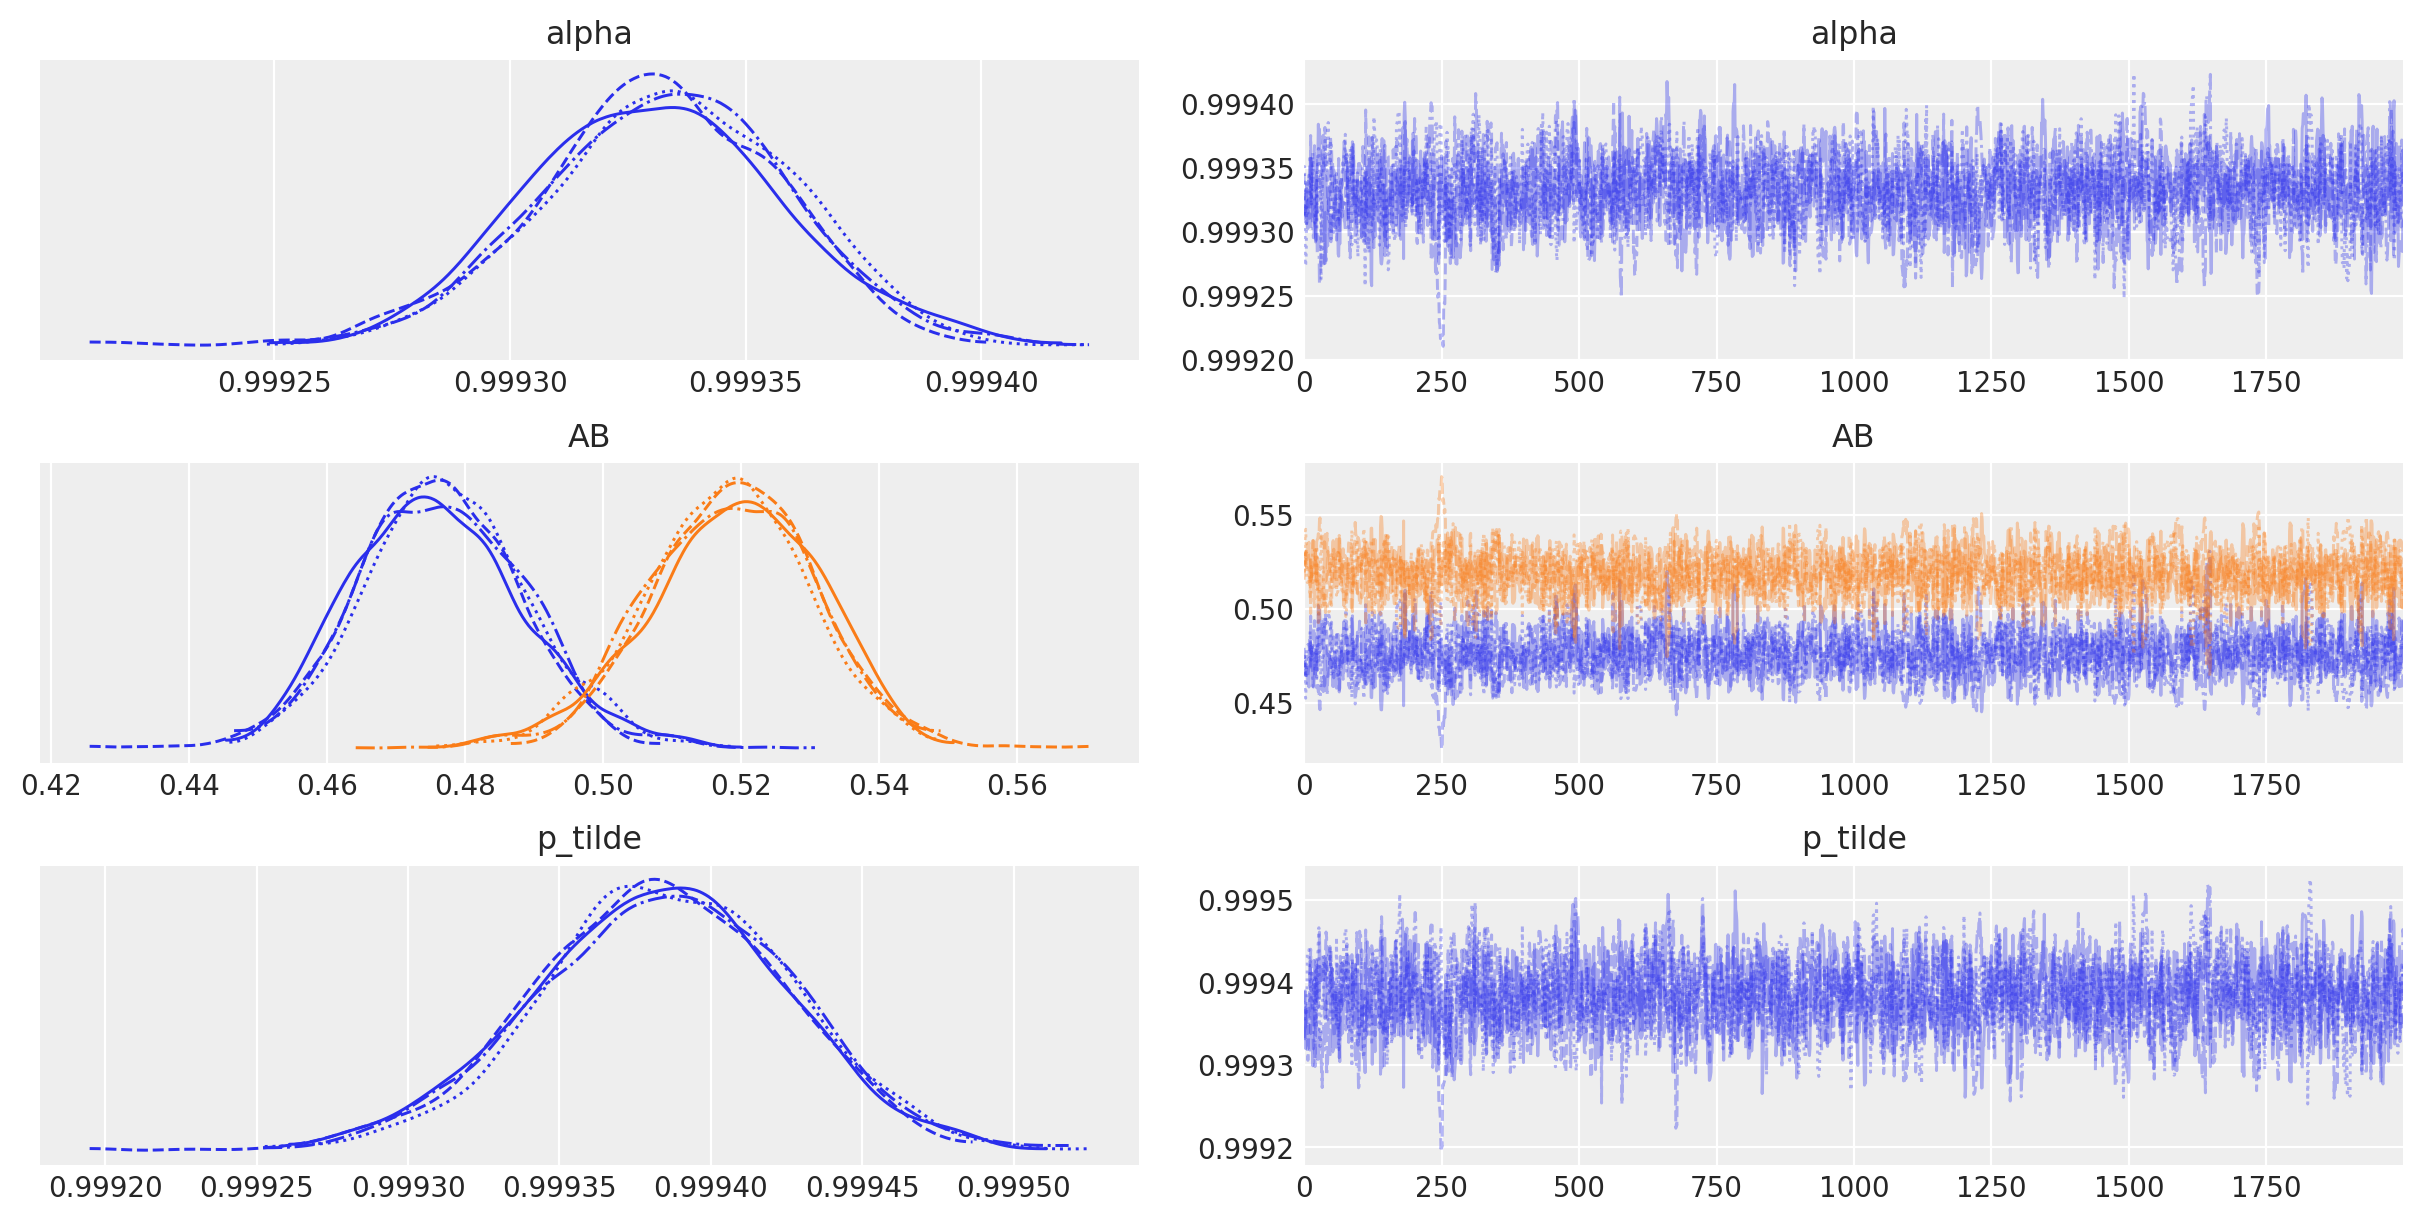

In [47]:
trace_t = bf.get_trace(tilde, target_accept = .95)

In [48]:
azt_summary = bf.get_summary(tilde, trace_t)
azt_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.999332,0.000026,0.999283,0.999382,0.000001,0.000001,1405.885996,1561.792157,1.002681
AB[0],0.476491,0.011945,0.454025,0.498399,0.000335,0.000237,1272.728267,1392.596048,1.003057
AB[1],0.518600,0.012063,0.496935,0.541632,0.000338,0.000240,1273.695234,1350.360216,1.003046
p_tilde,0.999384,0.000042,0.999308,0.999465,0.000001,0.000001,1508.418621,1945.992711,1.001516


####  Compute error per Clifford from SMC accelerated RB

In [49]:
epc_est_a = scale*(1 - azt_summary['mean']['p_tilde'])
epc_est_a_err = scale* (azt_summary['sd']['p_tilde'])

# Final comparison

In [56]:
# compare LSF and SMC
print("Model:            Frequentist                      Bayesian             Reference")
print("            two-run       accelerated        two-run       accelerated ")
print("EPC         {0:.6f}       {1:.6f}          {2:.6f}       {3:.6f}      {4:.6f}  "
      .format(epc_est_f ,epc_est_fm, epc_est_p, epc_est_a, epc_ref))   
print("± sigma     ± {0:.6f}     ± {1:.6f}        ± {2:.6f}     ± {3:.6f}     ------   "
      .format(epc_est_f_err, epc_est_fm_err, epc_est_p_err, epc_est_a_err))

Model:            Frequentist                      Bayesian             Reference
            two-run       accelerated        two-run       accelerated 
EPC         0.000444       0.000304          0.000456       0.000308      0.000319  
± sigma     ± 0.000072     ± 0.000028        ± 0.000046     ± 0.000021     ------   


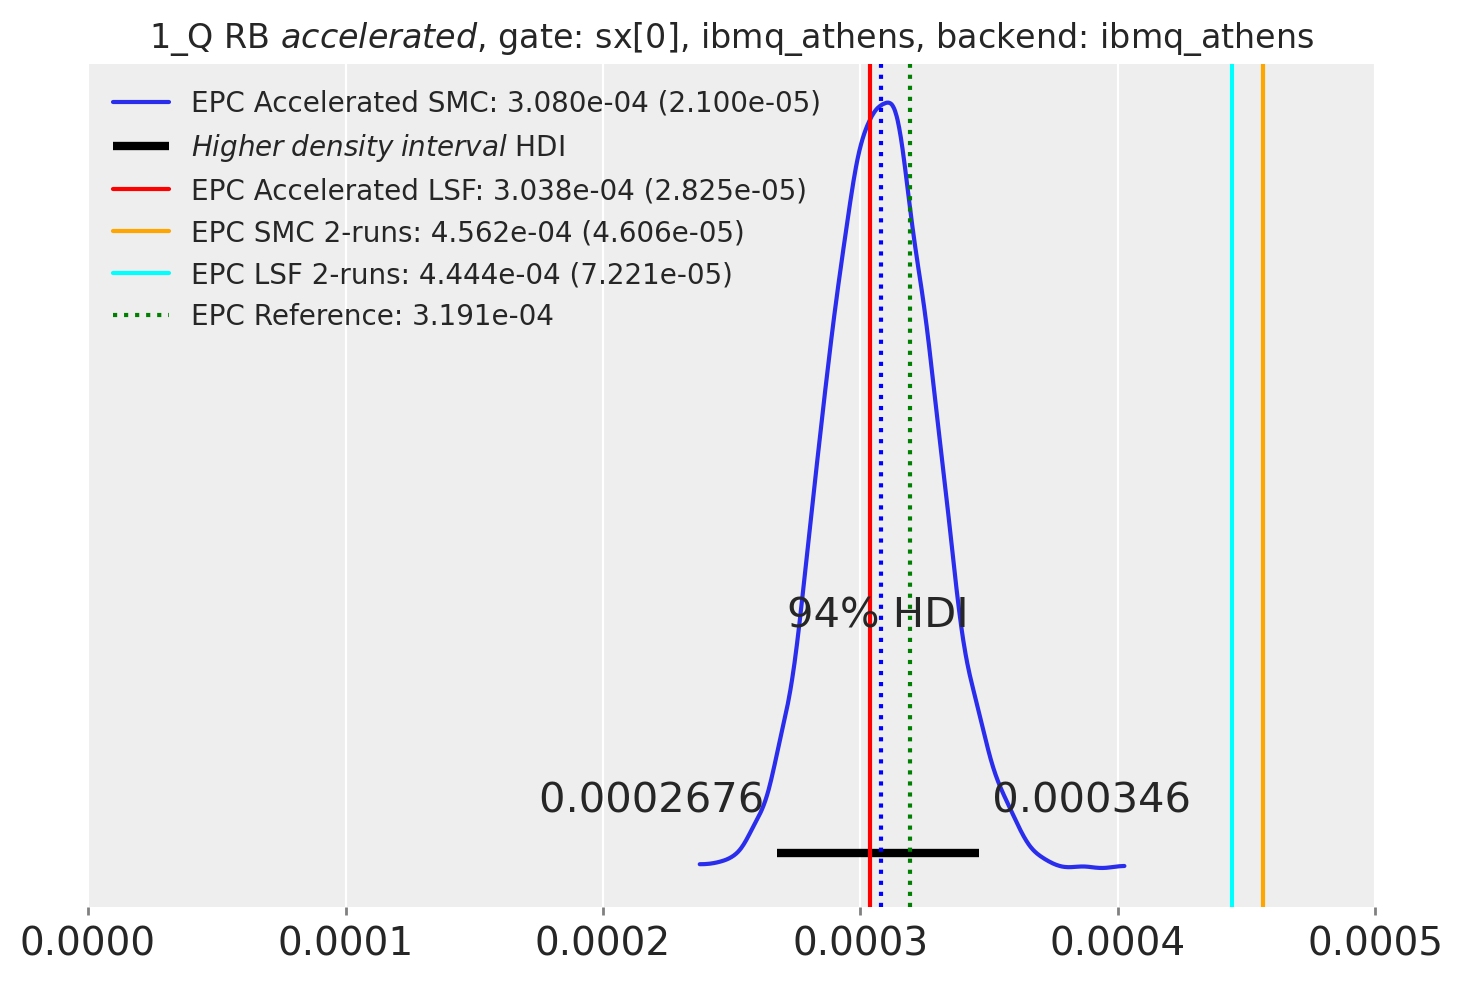

In [57]:
# obtain EPC from alpha (used by plot_posterior)
def alpha_to_EPC(alpha):
        return scale*(1-alpha)

# for refering the interleaved gate in the title of the graphs
intl_g=str(interleaved_gates[0][0][0:2])+str(rb_pattern[0][0:2])
if RB_process in ["3_Q RB","2-3_Q RB"] :
    intl_g=intl_g+"<"+str(interleaved_gates[1][0][0:1]+str(rb_pattern[1][0:2]))


import matplotlib.pyplot as plt # seems we need to reimport for replot WIP

with tilde:
        ax = az.plot_posterior(trace_t,  var_names=['p_tilde'], round_to=4, point_estimate=None, 
                          transform =  alpha_to_EPC)
        ax.set_xlim(0.0, 0.0005)
        plt.axvline(x=epc_est_fm,color='red',ls="-")
        plt.axvline(x=epc_est_p,color='orange',ls="-")
        plt.axvline(x=epc_est_f,color='cyan',ls="-")       
        if epc_ref > 0.0:
            plt.axvline(x=epc_ref,color='green',ls=":")
        plt.axvline(x=epc_est_a,color='blue',ls=":")
        plt.title(RB_process +' $accelerated$, gate: ' + intl_g\
                  +", "+hardware+', backend: '+backend.name(),
               fontsize=12)
        Bayes_legend =  "EPC Accelerated SMC: {0:1.3e} ({1:1.3e})".format(epc_est_a, epc_est_a_err)
        Bayes2_legend = "EPC SMC 2-runs: {0:1.3e} ({1:1.3e})".format(epc_est_p, epc_est_p_err)
        Fitter_legend = "EPC LSF 2-runs: {0:1.3e} ({1:1.3e})".format(epc_est_f, epc_est_f_err) 
        LSM_legend =    "EPC Accelerated LSF: {0:1.3e} ({1:1.3e})".format(epc_est_fm, epc_est_fm_err)  
        Cal_legend =    "EPC Reference: {0:1.3e}".format(epc_ref)
        if epc_ref > 0.0:   
            plt.legend((Bayes_legend, "$Higher\; density\; interval$ HDI",
                        LSM_legend,Bayes2_legend,
                        Fitter_legend,Cal_legend), fontsize=10 )
        else: 
            plt.legend((Bayes_legend, "$Higher\; density\; interval$ HDI",
                        LSM_legend, Bayes2_legend,
                        Fitter_legend), fontsize=10 )

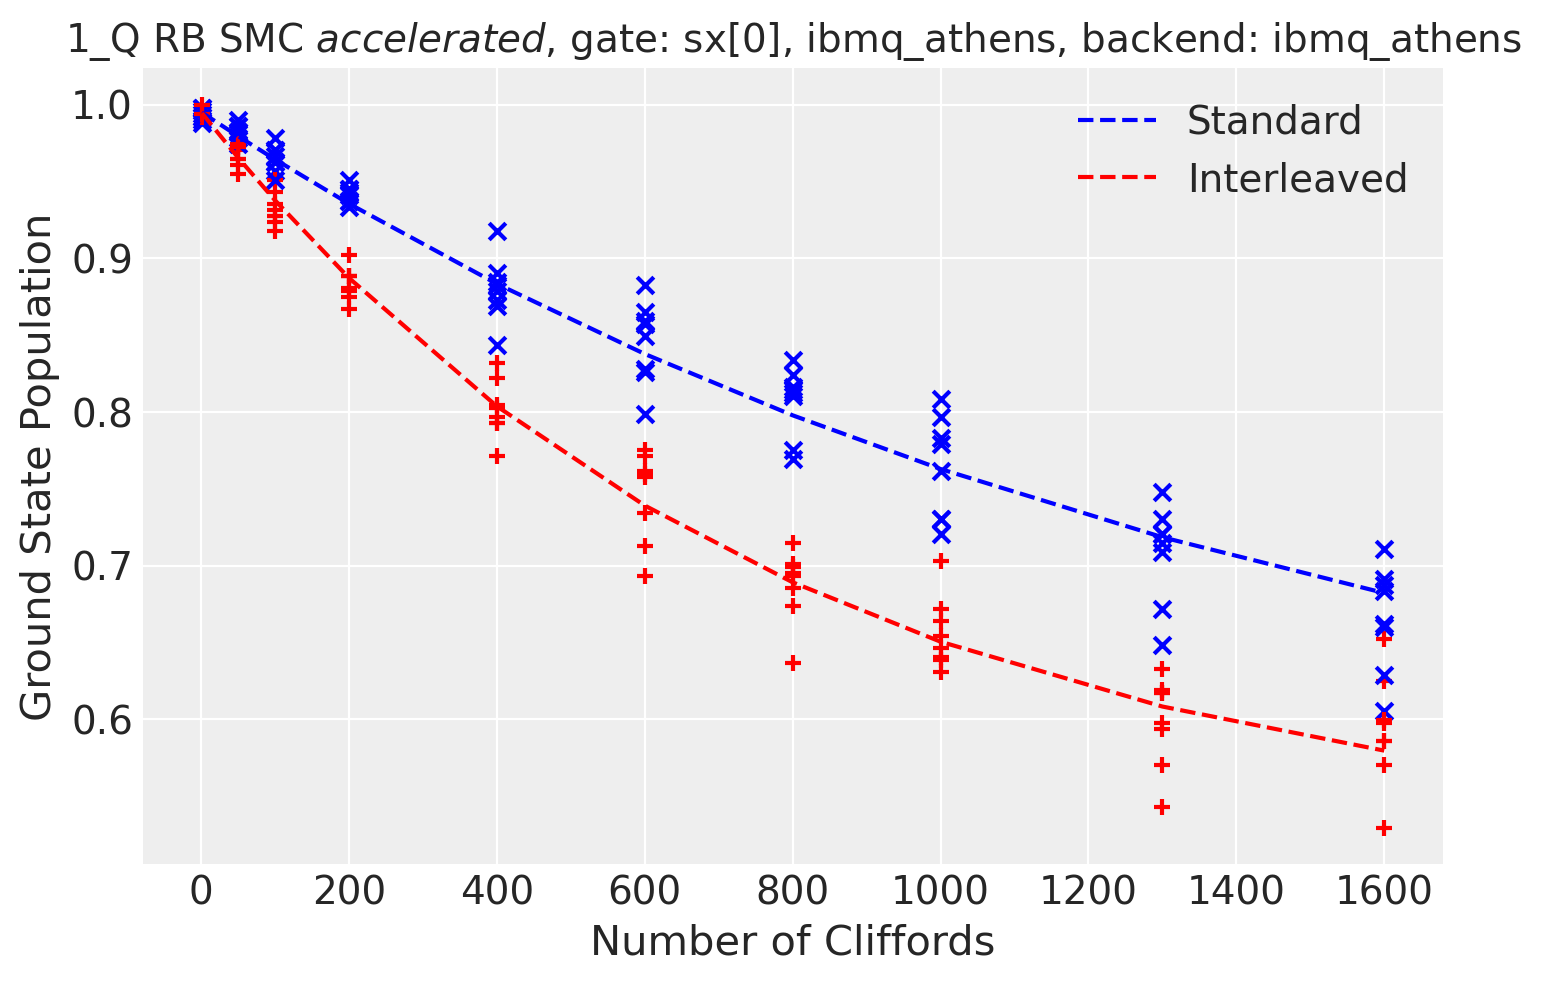

In [58]:
import matplotlib.pyplot as plt # seems we need to reimport for replot WIP

fig, plt = plt.subplots(1, 1)

plt.set_ylabel("Ground State Population")
plt.set_xlabel("Number of Cliffords")

for i_seed in range(nseeds):
    plt.scatter(nCliffs, Y1[i_seed,:]/shots, label = "data", marker="x",color="b")
    plt.scatter(nCliffs, Y2[i_seed,:]/shots, label = "data", marker="+",color="r")
plt.plot(nCliffs,azt_summary['mean']['AB[0]']*azt_summary['mean']['alpha']**nCliffs+\
          azt_summary['mean']['AB[1]'],'--',color="b")
plt.plot(nCliffs,azt_summary['mean']['AB[0]']*(azt_summary['mean']['alpha']*azt_summary['mean']['p_tilde'])**\
          nCliffs+azt_summary['mean']['AB[1]'],'--',color="r")

plt.legend(("Standard",
             "Interleaved"))

plt.set_title(RB_process +' SMC $accelerated$, gate: ' + intl_g\
                  +", "+hardware+', backend: '+backend.name(),
               fontsize=14);

In [53]:
import qiskit.tools.jupyter
%qiskit_version_table